# Main Code
All the functions and code for the extraction and analysis of the flight spare SXM angular response measurements

In [14]:
# Interval of bins (a,b)
a = 190
b = 221
#c = 215
#d = 215# approximate point where the two gaussians meet

In [32]:
import h5py
import os
import sys
from glob import glob
from math import factorial
from numpy import genfromtxt, sum, array,sqrt,zeros,exp,diag, pi,arange, sin, cos,vstack,log, mean, ones
from pylab import show, tight_layout, xticks,savefig, errorbar, scatter,legend, colorbar, xlabel, ylabel, title, imshow,plot, subplot, axvspan,xlim,ylim,stem,setp
from matplotlib import gridspec
from scipy.optimize import curve_fit


# Interval of bins (a,b)
#a = 190
#b = 221
#c = 210  # approximate point where the two gaussians meet

############################## Functions for calculations and plots ##############################


def sort_and_split_by_time(events,remover=0):
    sortedEvents = sort_mesurements_by_time(events,remover)
    values = 1
    for i in range(len(sortedEvents)):
        if i != (len(sortedEvents)-1):
            if sortedEvents[i][1] != sortedEvents[i+1][1]:
              values +=1

    splitEventList = []
    for i in range(values):
        splitEventList.append([])

    n = 0
    for i in range(values):
        splitEventList[i].append(sortedEvents[n])
        n +=1
        for j in range(n,len(sortedEvents)):
            if sortedEvents[j][1] == splitEventList[i][-1][1]:
                splitEventList[i].append(sortedEvents[j])
                n += 1
            else:
                break
    return splitEventList


# Sorts histograms from shortest time to longest
def sort_mesurements_by_time(events, remover=0):
    # Parameters--|
    # ---------------------------------------------------------
    # event       | list => [counts (1D array), time, filenames]
    # ---------------------------------------------------------
    # Returns-----|
    # ---------------------------------------------------------
    # eventsByTime| list => [counts (1D array), time, filenames]

    eventsByTime = []
    temp = []
    addedFiles = []

    # Sort data
    for i in events:
        temp.append(i[1])
    while len(temp) != 0:
        for j in events:
            if j[1] == min(temp) and (j[2] not in addedFiles):
                eventsByTime.append(j)
                addedFiles.append(j[2])
                temp.remove(min(temp))
                break
    indexList = []
    if remover==1:
        for i in range(len(eventsByTime)):
            if max(eventsByTime[i][0]) < 10:
                indexList.append(i)
        m = 0
        for n in indexList:
            eventsByTime.pop(n-m)
            m += 1
    return eventsByTime


# Gaussian curve equation function
def gaussian_curve(x, a1, p1, w1, a2=0, p2=0, w2=0, doubleGauss=0):
    # Parameters |
    #---------------------------
    # x          | bin number
    # a          | amplitude
    # p          | peak pos.
    # w          | width

    return a1*exp(-(4*log(2)*(x-p1)**2)/(w1**2))+a2*exp(-(4*log(2)*(x-p2)**2)/(w2**2))   # In terms of FWTM


# Returns the reduced Chi Square for a fit
def chi2_test(observed,expected,sumFit=0):
    # Parameters |
    #-------------------------------------------
    # observed   | array/list of measured values
    # expected   | array/list of the fit
    # wholeFit   | = 0 for individual Gaussian fits
    # ^^^^^^^^^^^| = 1 for both Gaussians fit

    chi2 = 0
    for i in range(len(observed)):
        chi2 += ((observed[i]-expected[i])**2)/expected[i]
    if sumFit:
        return chi2/(len(observed)-6)
    else:
        return chi2 / (len(observed) - 3)


# Returns the values corresponding to a Poisson function
def poisson_distribution(ocurrences,rate):
    # Parameters |
    #-------------------------
    # ocurrences | number of counts
    # rate       | count rate

    return (rate**ocurrences)/(factorial(ocurrences)*exp(rate))


# Plots the frequency of measurement of each count value
def count_frecuency(bns, allCPS):
    # Parameters |
    #-------------------------------------------
    # bns        | list => [multidimensional arrays (bins)]
    # allCPS     | list/array => [counts per second on each bin]

    counts = []
    reps = []
    frec = []
    totalMeasurements = 0
    for i in bns:
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                c = i[j][k]
                if c not in counts:
                    counts.append(c)
                    reps.append(1)
                else:
                    n = counts.index(c)
                    reps[n] += 1
        totalMeasurements += i.shape[0]*i.shape[1]
    for i in reps:
        frec.append(float(i)/totalMeasurements)
    scatter(counts,frec)

    averageCPS = mean(array(allCPS))
    fit = []
    for i in range(len(counts)):
        fit.append(poisson_distribution(i,averageCPS))
    plot(counts,fit,"--r", label="Poisson dist.", zorder=1)
    chi2 = chi2_test(frec,fit)
    print chi2
    xlabel("Counts")
    ylabel("Frequency")
    legend(loc="upper right")
    title("Count frequency")
    show()


# Returns a list with the fit values
def gaussian_fit(y, t1a, t2a, t3a, x1, x2,t1b=0, t2b=0, t3b=0, fullRange=1,multGaussian=0):
    # Parameters |
    #--------------------------------------------------
    # y          | list/array of measured y values
    # t1         | test parameter 1 (amplitude)
    # t2         | test parameter 2 (peak position
    # t3         | test parameter 3 (width)
    # x1         | start of interval to find fit param.
    # x2         | end of interval
    # fullRange  | = 1 returns fit values from a to b
    #^^^^^^^^^^^^| = 0 returns fit values from x2 to x2

    initValues = [t1a,t2a,t3a,t1b,t2b,t3b]

    fitValues = curve_fit(gaussian_curve,range(x1,x2),y,p0 = initValues)

    amp1 = fitValues[0][0]
    pkPos1 = fitValues[0][1]
    width1 = fitValues[0][2]

    paramErrors = sqrt(diag(fitValues[1]))

    amp1Err = paramErrors[0]
    pkPos1Err = paramErrors[1]
    width1Err = paramErrors[2]
    
    fit = []
    
    if multGaussian==0:
        if fullRange:
            for i in range(a,b):
                fit.append(gaussian_curve(i,amp1,pkPos1,width1))
        else:
            for i in range(x1,x2):
                fit.append(gaussian_curve(i,amp1,pkPos1,width1))
        fitData = [fit,amp1,pkPos1,width1, amp1Err,pkPos1Err,width1Err]
    elif multGaussian==1:
        amp2 = fitValues[0][3]
        pkPos2 = fitValues[0][4]
        width2 = fitValues[0][5]
        
        amp2Err = paramErrors[3]
        pkPos2Err = paramErrors[4]
        width2Err = paramErrors[5]
        
        for i in range(a,b):
            fit.append(gaussian_curve(i,amp1,pkPos1,width1, a2=amp2,p2=pkPos2,w2=width2))
        fitData = [fit,amp1,pkPos1,abs(width1),amp2,pkPos2,abs(width2),amp1Err,pkPos1Err,width1Err,amp2Err,pkPos2Err,width2Err]
    return fitData


# Plot bin histogram image
def plot_bin(bns, sect=0):
    # Parameters |
    #------------------------------------------------------
    # bns        | list => [multidimensional arrays (bins)]

    imshow(vstack(bns), origin='0', aspect="auto",cmap="plasma")
    if sect==1:
        axvspan(0,a, alpha=0.30, facecolor="black")               # Highlight selected
        axvspan(b,len(bns[1][0])-1, alpha=0.3, facecolor="black") # interval
    ylabel("Periods")
    xlabel("Bins")
    colorbar().set_label("Counts")


# Plot the angular response
def plot_angular_response(az, el, cps):
    # Parameters |
    #------------------------------------------------------
    # az         | list containing azimuth values
    # el         | list containing elevation values
    # cps        | list containing counts per second values

    angle = arange(0, 2 * pi, 0.01)
    for i in range(0,36,5):
        plot(i * cos(angle), i * sin(angle), "--k", alpha=0.25, zorder=1)

    scatter(az, el, c=cps, zorder=2,cmap="plasma")
    # title("SXM Angular Response (bins " + str(a) + " to " + str(b) + ")")
    xlabel("Azimuth (deg)")
    ylabel("Elevation (deg)")
    xlim(-40,40)
    ylim(-40,40)
    colorbar().set_label("Counts/sec")


# Plot 2 gaussian fits for the data
def fit_events_rms(events, returnFitParam=0, noRMS=0, remover=0,
                   customInitialParameters=0,amp1=0,pkPos1=0,width1=0,amp2=0,pkPos2=0,width2=0, 
                   multGaussian=0):
    
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # returnFitParam | = 0 plots the 2 gaussian fits
    # ^^^^^^^^^^^^^^^| = 1 returns list with fit parameters

    s = zeros(len(events[0][0]), float)
    if noRMS==0:
        for i in range(len(events)):
            # Sum squares
            s += (events[i][0])**2
        m = s / len(events)
        rms = sqrt(m)
    elif noRMS==1:
        for i in range(len(events)):
            s += (events[i][0])
        rms = s
    
    if customInitialParameters==0:
        amp1 = max(rms)
        pkPos1 = a+list(rms).index(max(rms))
        width1 = 10

        amp2 = max(rms[int(pkPos1)-a+10:])
        pkPos2 = pkPos1+10
        width2 = 10

    if multGaussian==0:
        fit1Data = gaussian_fit(rms[:(c-a)],amp1,pkPos1,width1,a,c)
        fit2Data = gaussian_fit(rms[(len(rms)-(b-d)):],amp2,pkPos2,width2,d,b)

        rmsFit1 = fit1Data[0]
        rmsFit2 = fit2Data[0]
        fitSum = array(rmsFit1)+array(rmsFit2)

        #chi2Fit1 = chisquare(rms[:(c-a)],rmsFit1[:(c-a)])[0]
        #chi2Fit2 = chisquare(rms[(c-a):],rmsFit2[(c-a):])[0]

        chi2Fit1 = chi2_test(rms[:(c-a)],rmsFit1[:(c-a)])
        chi2Fit2 = chi2_test(rms[(c-a):],rmsFit2[(c-a):])
        chi2FitSum = chi2_test(rms,fitSum,sumFit=1)

        if returnFitParam:
            return [[fit1Data,chi2Fit1],[fit2Data,chi2Fit2], chi2FitSum]
        else:

            plot(range(a, b), rms, "--o", label="Data RMS", zorder=1)
            plot(range(a, b), rmsFit1, "--", label=r"Fit 1 ")#($\chi^2$ = " +str(round(chi2Fit1,2)) + ")")
            plot(range(a, b), rmsFit2, "--", label=r"Fit 2 ")#($\chi^2$= " + str(round(chi2Fit2,2)) + ")")

            plot(range(a,b),fitSum, "--", label="Sum ($\chi^2$ = " +str(round(chi2FitSum,2)) + ")")
            legend(loc="upper right")
            xlabel("Bin Number")
            ylabel("Counts")
            
    if multGaussian==1:
        fitData = gaussian_fit(rms,amp1,pkPos1,width1,a,b,t1b=amp2,t2b=pkPos2,t3b=width2,multGaussian=multGaussian)
        fit = fitData[0]
        chi2Fit = chi2_test(rms,fit,sumFit=1)
        
        if returnFitParam:
            return [fitData,chi2Fit]
        else:
            plot(range(a,b),rms,"--o", label="Data")
            plot(range(a,b), fit,"--",label=r"Fit ($\chi^2$ = " +str(round(chi2Fit,2)) + ")")
            ylabel("Counts")
            xlabel("Bin Number")
            legend(loc="upper right")

            
# Plot counts vs bins for each individual bin array
def plot_events_all(events, removeBad=0, ordered=0,fit=0):
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    
    if ordered==1:
        if removeBad==0:
            eventsByTime = sort_mesurements_by_time(events)
        elif removeBad == 1:
            eventsByTime = sort_mesurements_by_time(events,1)
    elif ordered==0:
        eventsByTime=events
    
    n=0
    for i in eventsByTime:
        subplot(5,8,n+1)
        plot(range(a,b),i[0], label = str(i[1])+" sec")
        
        if fit==1:
            amp = max(i[0])
            pkPos = a + list(i[0]).index(max(i[0]))
            width = 10
            fit = gaussian_fit(i[0], amp, pkPos, width, a, b)[0]

            chi2 = chi2_test(i[0],fit)
            plot(range(a, b), fit, "--", label="Fit ($\chi^2$= " + str(round(chi2,2)) + ")")
            
        title(str(n+1), fontweight='bold')
        legend(loc="upper right")
        n+=1
    show()


# Plot counts vs bins for the RMS of several bin arrays
def fit_sections_rms(events, countsOnly=0, groupByTime=0,remover=0):
    # Parameters     |
    #--------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]

    if groupByTime==0:
        eventsByTime = sort_mesurements_by_time(events,remover)
        n=0
        m=0
        for i in range(0,len(eventsByTime), 6):
            subplot(3, 3, n + 1)
            eventSection = eventsByTime[i:i+6]
            if countsOnly == 0:
                fit_events_rms(eventSection)
            elif countsOnly == 1:
                fit_events_rms(eventSection,0,1)
            m+=len(eventSection)
            # title(str(i+1)+" to "+str(m))
            n+=1
    if groupByTime==1:

        eventsByTime = sort_and_split_by_time(events, remover)  # [:(len(sort_and_split_by_time(events,remover)))-2]
        eventsByTime.pop(len(eventsByTime) - 2)
        n=0
        for i in eventsByTime:
            subplot(3, 3, n + 1)
            fit_events_rms(i,0,0)
            n +=1
            title(str(i[0][1])+"s")

    show()


# Plot RMS fits and residuals
def rms_fit_and_residual_fit(events,s,mode=0, remover=0, groupByTime=0,multGaussian=0, noRMS=0):
    # Parameters     |
    # ------------------------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # mode           | = 0 plot by sections
    # ^^^^^^^^^^^^^^^| = 1 plot for grouped by time
    # ^^^^^^^^^^^^^^^| = 2 plot for overall RMS to be put along hist and ag response

    if mode == 1:
        if groupByTime == 0:
            eventsByTime = sort_mesurements_by_time(events,remover)
            if mode == 1:
                n = 0
                m = 0
                outerGrid = gridspec.GridSpec(2,5)
                for i in range(0, len(eventsByTime), s):
                    innerGrid = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=outerGrid[n])

                    eventSection = eventsByTime[i:i + s]
                    sp1 = subplot(innerGrid[0])
                    m += len(eventSection)
                    title(str(i+1)+" to "+str(m), fontweight='bold')
                    fit_events_rms(eventSection,multGaussian=multGaussian, noRMS=noRMS)
                    sp2 = subplot(innerGrid[1])
                    plot_residual_fit(eventSection,multGaussian=multGaussian, noRMS=noRMS)
                    setp(sp1.get_xticklabels(), visible=False)
                    n += 1
                show()

        elif groupByTime == 1:
            eventsByTime = sort_and_split_by_time(events, remover)  # [:(len(sort_and_split_by_time(events,remover)))-2]
            eventsByTime.pop(len(eventsByTime) - 2)
            n = 0
            outerGrid = gridspec.GridSpec(2, 3)
            for i in eventsByTime:
                innerGrid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outerGrid[n])
                sp1 = subplot(innerGrid[0])
                title(str(i[0][1]) + "s ("+str(len(i))+")",fontweight='bold')
                fit_events_rms(i,multGaussian=multGaussian, noRMS=noRMS)
                sp2 = subplot(innerGrid[1])
                plot_residual_fit(i,multGaussian=multGaussian, noRMS=noRMS)
                setp(sp1.get_xticklabels(), visible=False)
                n += 1
            show()

    elif mode== 0:
        sp1 = subplot(211)
        title("All Histograms RMS", fontweight = 'bold')
        fit_events_rms(events,multGaussian=multGaussian, noRMS=noRMS)
        subplot(212,sharex=sp1)
        plot_residual_fit(events,multGaussian=multGaussian, noRMS=noRMS)
        setp(sp1.get_xticklabels(), visible=False)
        show()
    elif mode == 2:
        sp1 = subplot(426)
        title("All Events RMS")
        fit_events_rms(events,multGaussian=multGaussian, noRMS=noRMS)
        subplot(428, sharex=sp1)
        plot_residual_fit(events,multGaussian=multGaussian, noRMS=noRMS)
        setp(sp1.get_xticklabels(), visible=False)
        show()


# Plot fit with residual
def plot_residual_fit(events,multGaussian=0, noRMS=0):
    # Parameters     |
    # -------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]

    s = zeros(len(events[0][0]), float)
    if noRMS == 0:
        for i in range(len(events)):
            # Sum squares
            s += (events[i][0]) ** 2
        m = s / len(events)
        rms = sqrt(m)
    elif noRMS==1:
        for i in range(len(events)):
            s += (events[i][0])
        rms = s

    #plot(range(a, b), rms, "--o", label="RMS")

    amp1 = max(rms)
    pkPos1 = a + list(rms).index(max(rms))
    width1 = 10

    amp2 = max(rms[int(pkPos1) - a + 10:])
    pkPos2 = pkPos1 + 10
    width2 = 7

    #totalFit = rmsFit1+rmsFit2
    if multGaussian==0:
        rmsFit1 = gaussian_fit(rms[:(c - a)], amp1, pkPos1, width1, a, c)[0]
        rmsFit2 = gaussian_fit(rms[(c - a):], amp2, pkPos2, width2, c, b)[0]
        totalFit = array(rmsFit1)+array(rmsFit2)
    elif multGaussian==1:
        totalFit = gaussian_fit(rms,amp1,pkPos1,width1,a,b,t1b=amp2,t2b=pkPos2,t3b=width2,multGaussian=multGaussian)[0]
    
    chi2 = chi2_test(rms, totalFit,1)
    #plot(range(a,b),totalFit,"--r",label=r"Fit ($\chi^2$ = "+str(round(chi2,2))+")")


    residual = array(rms) - array(totalFit)
    stem(range(a,b),residual,"--c","oc", label="Residual") #(Avg = "+str(round(mean(residual),2))+")")
    xlabel("Bin Number")
    ylabel("Residual")
    legend(loc="upper right")


# Plot parameter data from the fits
def plot_fit_parameters(events, s=6, remover=0, groupByTime=0,multGaussian=0, noRMS=0):
    # Parameters     |
    # -------------------------------------------------------------
    # event          | list => [counts (1D array), time, filenames]
    # s              | int => number of histograms in one section

    listOfFitParameters = []
    
    chi2F1 = []
    ampF1 = []
    pkPosF1 = []
    widthF1 = []

    ampErrF1 = []
    pkPosErrF1 = []
    widthErrF1 = []

    chi2F2 = []
    ampF2 = []
    pkPosF2 = []
    widthF2 = []

    ampErrF2 = []
    pkPosErrF2 = []
    widthErrF2 = []
    
    Chi2 = []
    
    if groupByTime==0:
        eventsByTime = sort_mesurements_by_time(events,remover)
        for i in range(0,len(eventsByTime), s):
            eventSection = eventsByTime[i:i + s]
            listOfFitParameters.append(fit_events_rms(eventSection,returnFitParam=1,multGaussian=multGaussian,noRMS=noRMS))
    elif groupByTime==1:
        times = []
        eventsByTime = sort_and_split_by_time(events,remover) #[:(len(sort_and_split_by_time(events,remover)))-2]
        eventsByTime.pop(len(eventsByTime)-2)
        for i in eventsByTime:
            times.append((i[0][1]))
            listOfFitParameters.append(fit_events_rms(i,multGaussian=multGaussian,noRMS=noRMS,returnFitParam=1))
            
    if multGaussian==0:
        for i in listOfFitParameters:      # listOfFitParameters[i]
            chi2F1.append(i[0][1])         # |__[[fit1Data,chi2Fit1],[fit2Data,chi2Fit2],chi2FitSum]
            ampF1.append(i[0][0][1])       #         |         |__number
            pkPosF1.append(i[0][0][2])     #         |____list => [i] = [fit,amp,pkPos,width,ampErr,pkPosErr,widthErr]
            widthF1.append(i[0][0][3])     #                         (from gaussian fit)
            ampErrF1.append(i[0][0][4])
            pkPosErrF1.append(i[0][0][5])
            widthErrF1.append(i[0][0][6])

            chi2F2.append(i[1][1])
            ampF2.append(i[1][0][1])
            pkPosF2.append(i[1][0][2])
            widthF2.append(i[1][0][3])
            ampErrF2.append(i[1][0][4])
            pkPosErrF2.append(i[1][0][5])
            widthErrF2.append(i[1][0][6])

            Chi2.append(i[2])
            
    elif multGaussian==1:
        for i in listOfFitParameters:
            Chi2.append(i[1])           # |__[[fitData,chi2Fit]]
            ampF1.append(i[0][1])       #         |         |__number
            pkPosF1.append(i[0][2])     #         |____list => [i] = [fit,amp,pkPos,width,ampErr,pkPosErr,widthErr]
            widthF1.append(i[0][3])     
            ampF2.append(i[0][4])
            pkPosF2.append(i[0][5])
            widthF2.append(i[0][6])

            ampErrF1.append(i[0][7])
            pkPosErrF1.append(i[0][8])
            widthErrF1.append(i[0][9])
            ampErrF2.append(i[0][10])
            pkPosErrF2.append(i[0][11])
            widthErrF2.append(i[0][12])
    
    subplot(411)
    plot(Chi2, label="$\chi^2$")
    xticks(range(len(Chi2)),times)
    legend(loc="upper left")
    
    sp1 = subplot(423)
    errorbar(range(len(pkPosF1)),pkPosF1,yerr=pkPosErrF1, color="r",label="Peak Position")
    xticks(range(len(pkPosF1)),times)
    #ylim(201, 204)
    title("Peak 1")
    legend(loc="upper left")

    subplot(425,sharex=sp1)
    setp(sp1.get_xticklabels(), visible=False)
    #plot(chi2F1, label="$\chi^2$")
    #errorbar(range(len(ampF1)),ampF1,yerr=ampErrF1, label="Height")
    errorbar(range(len(widthF1)),widthF1, yerr=widthErrF1,label="Width")
    xticks(range(len(widthF1)),times)
    legend(loc="upper left")

    sp2 = subplot(424)
    errorbar(range(len(pkPosF2)),pkPosF2,yerr=pkPosErrF1, color ="r", label="Peak Position")
    #ylim(210, 215)
    xticks(range(len(pkPosF2)),times)
    title("Peak 2")
    legend(loc="upper left")

    subplot(426, sharex=sp2)
    setp(sp2.get_xticklabels(), visible=False)
    #plot(chi2F2, label="$\chi^2$")
    #errorbar(range(len(ampF2)),ampF2, yerr=ampErrF2, label="Height")
    errorbar(range(len(widthF2)), widthF2, yerr=widthErrF2, label="Width")
    xticks(range(len(widthF2)),times)
    legend(loc="upper left")
    show()

    
############################## Data extraction from hdf5 files ##############################

h5FilesDir = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/h5_files"
logfilesTablePath = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/data_table.txt"

tableData = genfromtxt(logfilesTablePath, str)   # Data from angular response measurements

# Gets all the .h5 files from the specified directory
if h5FilesDir.endswith("/"):
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)
else:
    h5FilesDir += "/"
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)

countsPerSec = []     # Contains cps for each bin
elevation = []        # Values for elevation (deg)
azimuth = []          # Values for azimuth (deg)
binList = []          # Contains the arrays for each individual 'bin'
eventsTimeList = []   # [All counts, total time, name of the file] to be sorted by time
counts = []           # All counts on each 'bin' array
counts1 = []
bns = []

for i in filePaths:
    fileName = i[len(h5FilesDir):(len(i) - len(".h5"))]

    # Find files in the directory that match with the files on the table
    for m in tableData:
        if m[2] == fileName:  # m[2] is the logfile name on table

            # Calculate counts per second
            dataFile = h5py.File(i)
            binList.append(dataFile['data/tlm_sxm_data/hdr']['bin'])
            bins = dataFile['data/tlm_sxm_data/hdr']['bin'][:, a:b]
            dataFile.close()

            s = sum(bins, 1)
            totalTime = float(32 * len(s) / 2 + 18 * len(s) / 2)
            totalCounts = sum(bins)
            totalCounts1 = sum(bins[:35,:])
            cps = totalCounts / totalTime

            azimuth.append(float(m[0]))
            elevation.append(float(m[1]))
            countsPerSec.append(cps)
            eventsTimeList.append([sum(bins,0), totalTime, fileName])
            counts.append(totalCounts)
            counts1.append(totalCounts1)
            bns.append(bins)

<IPython.core.display.Javascript object>


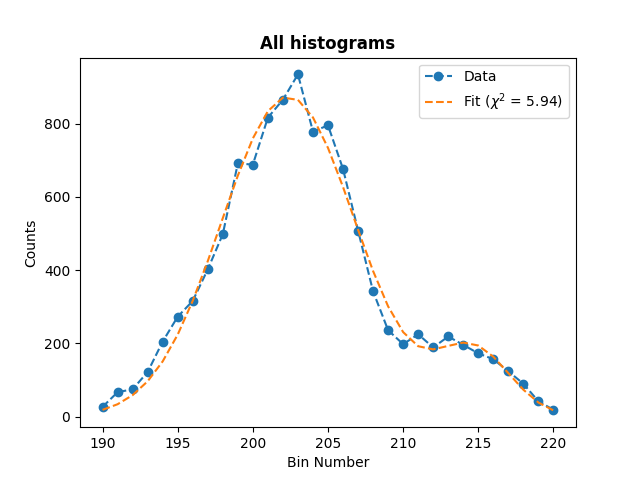

Text(0.5,1,u'All histograms')

In [38]:
%matplotlib notebook
fit_events_rms(eventsTimeList,remover=1,noRMS=1, multGaussian=1)
title("All histograms", fontweight="bold")

# Parameter evolution

<IPython.core.display.Javascript object>


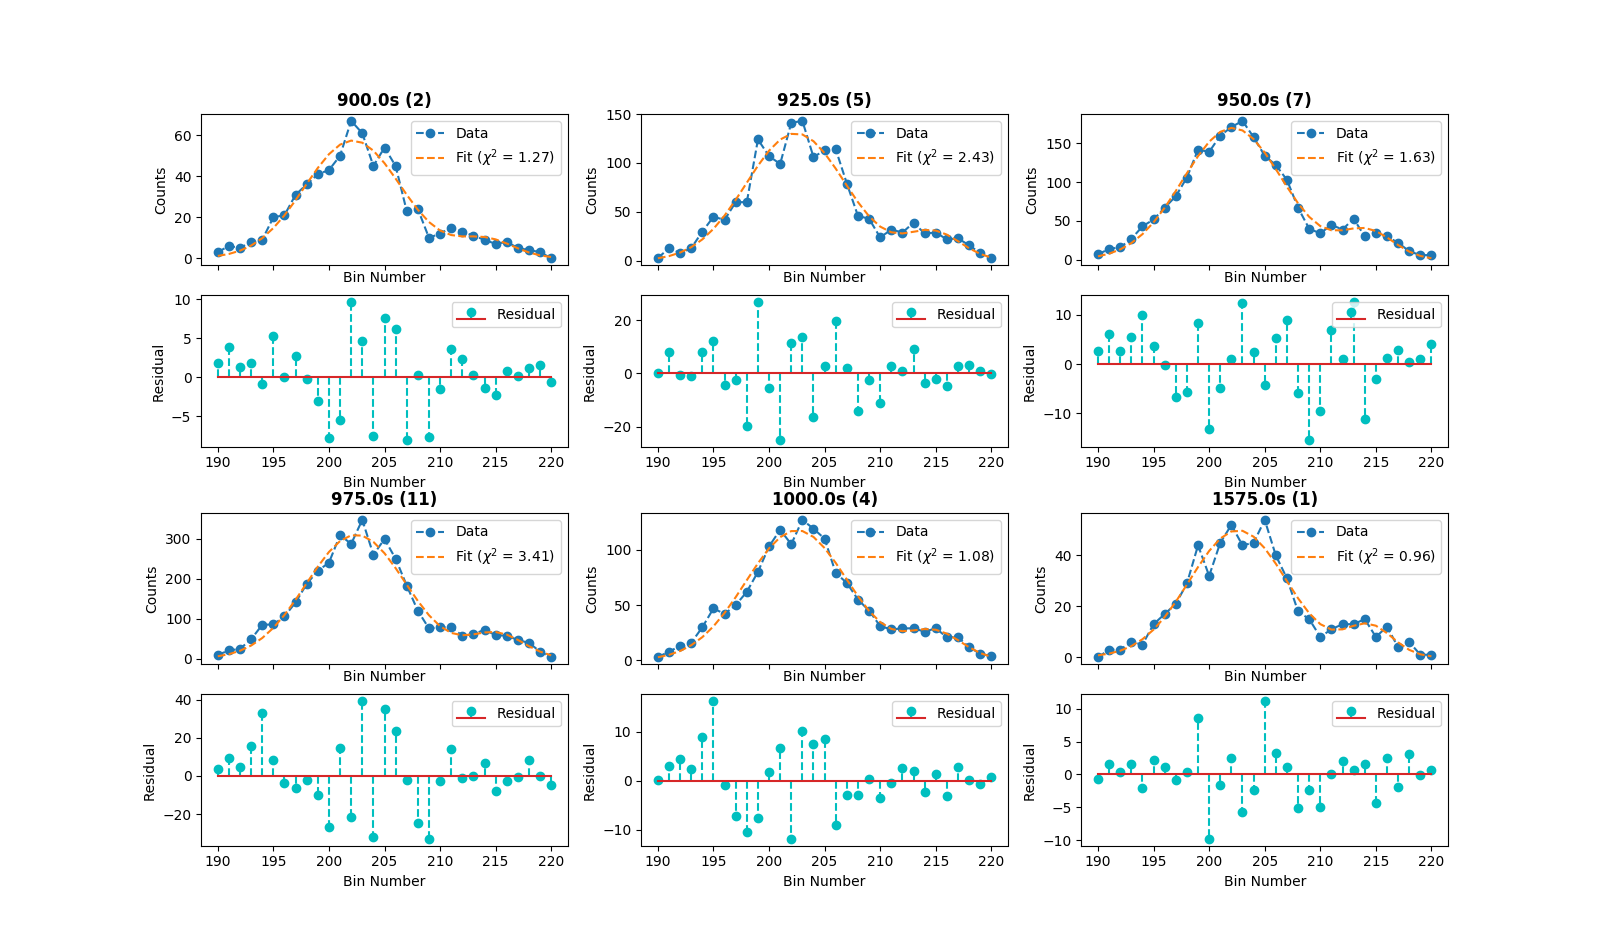

In [36]:
%matplotlib notebook
rms_fit_and_residual_fit(eventsTimeList, s=6,mode=1,noRMS=1,multGaussian=1,remover=1,groupByTime=1)

<IPython.core.display.Javascript object>


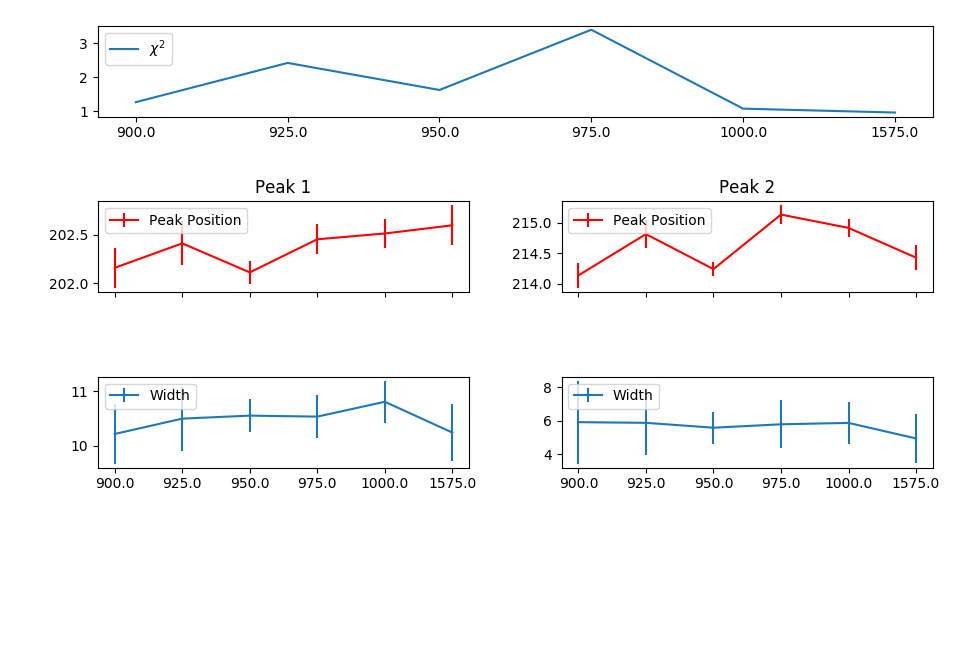

In [25]:
%matplotlib notebook
plot_fit_parameters(eventsTimeList,remover=1,noRMS=1,multGaussian=1,groupByTime=1)
tight_layout()